# **Bioinformatics Project - Computational Drug Discovery [Part 4] Classification Models Building**

**MOUNSIF EL ATOUCH**

In this Jupyter notebook, we will be building a machine learning model using the ChEMBL bioactivity data.

In **Part 4**, we will be building classification models

---

## **Importing libraries**

In [86]:
import os
import pandas as pd

from scipy.spatial.distance import *
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

seed = 42

from sklearn.model_selection import *
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import *

from scipy import interp
from math import *
from sklearn.metrics import RocCurveDisplay

import warnings
warnings.filterwarnings('ignore')

In [87]:
from sklearn.ensemble import ExtraTreesClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC  
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

In [88]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [89]:
def print_auc(clf, X_train, y_train, X_test, y_test, model_name) :
    
    clf = clf.fit(X_train, y_train)
    y_pred_proba = clf.predict_proba(X_test)[::,1]
    fpr, tpr, thr = roc_curve(y_test,  y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    #plt.plot(fpr, tpr, label=model_name+" auc="+str(roc_auc))
    #plt.legend(loc=4)
    #plt.title("ROC curve")

    #plt.show()
    # Data to plot precision - recall curve
    precision, recall, thresholds_log = precision_recall_curve(y_test, y_pred_proba)
    # Use AUC function to calculate the area under the curve of precision recall curve
    auc_precision_recall = auc(recall, precision)
    
    #plt.plot(recall, precision, label=model_name+" auc_prc="+str(auc_precision_recall))
    #plt.xlabel("Recall")
    #plt.ylabel("Precision")
    #plt.legend(loc=4)
    #plt.title("Precision-Recall Curve")

    #plt.show()
    precision_sc=precision_score(y_test, clf.predict(X_test), average=None)
    recall_sc = recall_score(y_test, clf.predict(X_test), average=None)
    test_score = accuracy_score(y_test, clf.predict(X_test)) * 100
    train_score = accuracy_score(y_train, clf.predict(X_train)) * 100
    f1 = f1_score(y_test, clf.predict(X_test))
    print_score(clf, X_train, y_train, X_test, y_test, train=True)
    print_score(clf, X_train, y_train, X_test, y_test, train=False)
    metriques = {"fpr" : fpr, "recall_sc" : recall_sc, "precision_sc" : precision_sc, "tpr" : tpr,
                 "test_score" : test_score, "train_score" : train_score, "f1" : f1,
                 "auc_pr" : auc_precision_recall, "auc": roc_auc}
    return metriques

## **Load the data set**

In [90]:
! wget https://raw.githubusercontent.com/mounsifelatouch/cdd/master/data/bioactivity_data_PubchemFingerprinter.csv

--2023-06-03 01:23:54--  https://raw.githubusercontent.com/mounsifelatouch/cdd/master/data/bioactivity_data_PubchemFingerprinter.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1154424 (1.1M) [text/plain]
Saving to: 'bioactivity_data_PubchemFingerprinter.csv'

     0K .......... .......... .......... .......... ..........  4%  149K 7s
    50K .......... .......... .......... .......... ..........  8% 11.4K 49s
   100K .......... .......... .......... .......... .......... 13% 9.17K 66s
   150K .......... .......... .......... .......... .......... 17% 14.8K 63s
   200K .......... .......... .......... .......... .......... 22% 30.5K 53s
   250K .......... .......... .......... .......... .......... 26% 30.9K 46s
   300K .......... .......... .......... .

In [91]:
df = pd.read_csv('bioactivity_data_PubchemFingerprinter.csv')
df

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,Activity
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
644,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
645,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
646,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## **Input features**

### **Input features**

In [92]:
X = df.drop('Activity', axis=1)

### **Output features**

In [93]:
y = df['Activity']

In [94]:
# count the number of instances in each class
counts = y.value_counts()

# calculate the ratio of the negative class to the positive class
imbalance_ratio = counts[0] / counts[1]

### **Let's examine the data dimension**

In [95]:
X.shape, y.shape

((648, 881), (648,))

### **Remove low variance features**

In [96]:
! pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable


In [97]:
import statsmodels.api as sm

def forward_selection(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

In [98]:
best_features = forward_selection(X, y)

In [99]:
len(best_features)

71

In [100]:
X = X[best_features]

In [101]:
X.shape

(648, 71)

## **Data split (80/20 ratio)**

In [102]:
n = np.arange(len(X))
idx_train, idx_test = train_test_split(n, test_size=.2, random_state=seed)

In [103]:
X_train, y_train = X.loc[idx_train], y.loc[idx_train]
X_test, y_test = X.loc[idx_test], y.loc[idx_test]

In [104]:
X_train.shape, y_train.shape

((518, 71), (518,))

In [105]:
y_test.value_counts()

0    118
1     12
Name: Activity, dtype: int64

## **Data balancing**

### **Random Oversampling**

In [106]:
from imblearn.over_sampling import RandomOverSampler

# create an oversampler object with a 1:1 ratio of positive to negative samples
ros = RandomOverSampler(sampling_strategy='minority')

# fit and apply the oversampler to the training data
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

### **SMOTE**

In [107]:
from imblearn.over_sampling import SMOTE

# Perform oversampling on the minority class in the training set
sm = SMOTE(random_state=seed)

# fit and apply the oversampler to the training data
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

### **ADASYN**

In [108]:
from imblearn.over_sampling import ADASYN

# Perform oversampling on the minority class in the training set
adasyn = ADASYN(random_state=seed)

# fit and apply the oversampler to the training data
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)



---



In [109]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [110]:
n_samples, n_classes = X_train.shape[0], 2
class_weights = dict(zip(np.unique(y_train), n_samples / (n_classes * np.bincount(y_train))))

# **GridSearchCV**
* cv = 10
* *`'balanced_accuracy'`* as a scoring metric to deal with imbalanced datasets. It is defined as the average of recall obtained on each class.

In [111]:
best_params = []

## **ExtraTreesClassifier**

In [114]:
clf1 = ExtraTreesClassifier(random_state=seed, class_weight='balanced')
param_grid = {'n_estimators': [100, 500, 1000],
              'max_depth': [10, 25, 50, 100],
              'max_features': [int(sqrt(X.shape[1])), int(log2(X.shape[1]))],
              'min_samples_split' : [2, 5, 10], 
              'min_samples_leaf' : [1, 5, 10],
              'class_weight' : ['balanced', None]}

# Define the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(clf1, param_grid=param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the training data
grid_search.fit(X_train, y_train)
best_params.append(grid_search.best_params_)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best hyperparameters to fit the model to the training data
clf_best = ExtraTreesClassifier(**grid_search.best_params_, random_state=seed)
model1 = clf_best.fit(X_train, y_train)

clf1 = print_auc(model1, X_train, y_train, X_test, y_test, 'ExtraTreesClassifier')
df1 = pd.DataFrame(data=[['ExtraTreesClassifier', clf1['f1'], clf1['auc'], clf1['auc_pr'], clf1['recall_sc'][0], clf1['recall_sc'][1], clf1['precision_sc'][0], clf1['precision_sc'][1]]], 
                          columns=['model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
df1.style.hide_index()

Best hyperparameters:  {'class_weight': 'balanced', 'max_depth': 25, 'max_features': 8, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Best mean cross-validation score: 0.82
Train Result:
Accuracy Score: 91.31%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.990847   0.493827  0.913127    0.742337      0.948629
recall       0.913502   0.909091  0.913127    0.911297      0.913127
f1-score     0.950604   0.640000  0.913127    0.795302      0.924220
support    474.000000  44.000000  0.913127  518.000000    518.000000
_______________________________________________
Confusion Matrix: 
 [[433  41]
 [  4  40]]

Test Result:
Accuracy Score: 80.00%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.950980   0.250000       0.8    0.600490      0.886275
recall       0.

model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
ExtraTreesClassifier,0.350000,0.743997,0.505599,0.822034,0.583333,0.950980,0.250000


## **XGBClassifier**

In [115]:
clf2 = xgb.XGBClassifier(objective='binary:logistic')
param_grid = {'learning_rate' : [0.01, 0.1, 0.2],
              'max_depth' : [3, 10, 25],
              'gamma' : [0.1, 0.5, 1.0],
              'subsample': [0.5, 0.8, 1.0],
              'colsample_bytree': [0.5, 0.8, 1.0],
              'scale_pos_weight': [1, imbalance_ratio]}

# Define the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(clf2, param_grid=param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the training data
grid_search.fit(X_train, y_train)
best_params.append(grid_search.best_params_)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best hyperparameters to fit the model to the training data
clf_best = xgb.XGBClassifier(**grid_search.best_params_, objective='binary:logistic')
model2 = clf_best.fit(X_train, y_train)

clf2 = print_auc(model2, X_train, y_train, X_test, y_test, 'XGBClassifier')
df2 = pd.DataFrame(data=[['XGBClassifier', clf2['f1'], clf2['auc'], clf2['auc_pr'], clf2['recall_sc'][0], clf2['recall_sc'][1], clf2['precision_sc'][0], clf2['precision_sc'][1]]], 
                          columns=['model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
df2.style.hide_index()

Best hyperparameters:  {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.2, 'max_depth': 10, 'scale_pos_weight': 10.571428571428571, 'subsample': 0.5}
Best mean cross-validation score: 0.85
Train Result:
Accuracy Score: 91.31%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.990847   0.493827  0.913127    0.742337      0.948629
recall       0.913502   0.909091  0.913127    0.911297      0.913127
f1-score     0.950604   0.640000  0.913127    0.795302      0.924220
support    474.000000  44.000000  0.913127  518.000000    518.000000
_______________________________________________
Confusion Matrix: 
 [[433  41]
 [  4  40]]

Test Result:
Accuracy Score: 85.38%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.954128   0.333333  0.853846    0.643731      0.896824
recall     

model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
XGBClassifier,0.424242,0.793079,0.498210,0.881356,0.583333,0.954128,0.333333


## **AdaBoostClassifier**

In [116]:
clf3 = AdaBoostClassifier(random_state=seed)
param_grid = {'n_estimators': [50, 100, 200],
              'learning_rate': [0.01, 0.1, 0.2],
              'base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=3)]}

# Define the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(clf3, param_grid=param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the training data
grid_search.fit(X_train, y_train)
best_params.append(grid_search.best_params_)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best hyperparameters to fit the model to the training data
clf_best = AdaBoostClassifier(**grid_search.best_params_, random_state=seed)
model3 = clf_best.fit(X_train, y_train)

clf3 = print_auc(model3, X_train, y_train, X_test, y_test, 'AdaBoostClassifier')
df3 = pd.DataFrame(data=[['AdaBoostClassifier', clf3['f1'], clf3['auc'], clf3['auc_pr'], clf3['recall_sc'][0], clf3['recall_sc'][1], clf3['precision_sc'][0], clf3['precision_sc'][1]]], 
                          columns=['model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
df3.style.hide_index()

Best hyperparameters:  {'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.2, 'n_estimators': 200}
Best mean cross-validation score: 0.74
Train Result:
Accuracy Score: 96.72%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.971134   0.909091  0.967181    0.940112      0.965864
recall       0.993671   0.681818  0.967181    0.837745      0.967181
f1-score     0.982273   0.779221  0.967181    0.880747      0.965026
support    474.000000  44.000000  0.967181  518.000000    518.000000
_______________________________________________
Confusion Matrix: 
 [[471   3]
 [ 14  30]]

Test Result:
Accuracy Score: 91.54%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.942149   0.555556  0.915385    0.748852      0.906463
recall       0.966102   0.416667  0.915385    0.6

model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
AdaBoostClassifier,0.476190,0.585452,0.283489,0.966102,0.416667,0.942149,0.555556


## **DecisionTreeClassifier**

In [117]:
clf4 = DecisionTreeClassifier(random_state=seed)
param_grid = {'min_samples_split': [2, 5, 10, 20],
              'max_depth': [2, 3, 4, 5, None],
              'min_samples_leaf': [1, 2, 4, 8],
              'criterion' : ['gini', 'entropy', 'log_loss'],
              'max_features': ['auto', int(sqrt(X.shape[1])), int(log2(X.shape[1]))]}

# Define the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(clf4, param_grid=param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the training data
grid_search.fit(X_train, y_train)
best_params.append(grid_search.best_params_)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best hyperparameters to fit the model to the training data
clf_best = DecisionTreeClassifier(**grid_search.best_params_, random_state=seed)
model4 = clf_best.fit(X_train, y_train)

clf4 = print_auc(model4, X_train, y_train, X_test, y_test, 'DecisionTreeClassifier')
df4 = pd.DataFrame(data=[['DecisionTreeClassifier', clf4['f1'], clf4['auc'], clf4['auc_pr'], clf4['recall_sc'][0], clf4['recall_sc'][1], clf4['precision_sc'][0], clf4['precision_sc'][1]]], 
                          columns=['model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
df4.style.hide_index()

Best hyperparameters:  {'criterion': 'gini', 'max_depth': None, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best mean cross-validation score: 0.68
Train Result:
Accuracy Score: 96.72%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.969199   0.935484  0.967181    0.952342      0.966335
recall       0.995781   0.659091  0.967181    0.827436      0.967181
f1-score     0.982310   0.773333  0.967181    0.877822      0.964559
support    474.000000  44.000000  0.967181  518.000000    518.000000
_______________________________________________
Confusion Matrix: 
 [[472   2]
 [ 15  29]]

Test Result:
Accuracy Score: 92.31%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.942623   0.625000  0.923077    0.783811      0.913304
recall       0.974576   0.416667  0.92307

model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
DecisionTreeClassifier,0.500000,0.651130,0.461142,0.974576,0.416667,0.942623,0.625000


## **GaussianNB**

In [118]:
clf5 = GaussianNB()
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

# Define the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(clf5, param_grid=param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the training data
grid_search.fit(X_train, y_train)
best_params.append(grid_search.best_params_)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best hyperparameters to fit the model to the training data
clf_best = GaussianNB(**grid_search.best_params_)
model5 = clf_best.fit(X_train, y_train)

clf5 = print_auc(model5, X_train, y_train, X_test, y_test, 'GaussianNB')
df5 = pd.DataFrame(data=[['GaussianNB', clf5['f1'], clf5['auc'], clf5['auc_pr'], clf5['recall_sc'][0], clf5['recall_sc'][1], clf5['precision_sc'][0], clf5['precision_sc'][1]]], 
                          columns=['model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
df5.style.hide_index()

Best hyperparameters:  {'var_smoothing': 1e-05}
Best mean cross-validation score: 0.68
Train Result:
Accuracy Score: 82.43%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.957041   0.262626  0.824324    0.609833      0.898056
recall       0.845992   0.590909  0.824324    0.718450      0.824324
f1-score     0.898096   0.363636  0.824324    0.630866      0.852698
support    474.000000  44.000000  0.824324  518.000000    518.000000
_______________________________________________
Confusion Matrix: 
 [[401  73]
 [ 18  26]]

Test Result:
Accuracy Score: 67.69%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.922222   0.125000  0.676923    0.523611      0.848632
recall       0.703390   0.416667  0.676923    0.560028      0.676923
f1-score     0.798077   0.192308  0.676923    0.495192

model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
GaussianNB,0.192308,0.700565,0.293542,0.703390,0.416667,0.922222,0.125000


## **LGBMClassifier**

In [120]:
clf6 = lgb.LGBMClassifier()
param_grid = {'num_leaves': [10, 20, 30],
              'max_depth': [3, 5, 7],
              'learning_rate': [0.01, 0.1],
              'n_estimators': [50, 100, 200],
              'min_child_samples': [10, 20, 30],
              'subsample': [0.8, 0.9, 1.0],
              'colsample_bytree': [0.8, 0.9, 1.0],
              'class_weight' : ['balanced', None, class_weights]}
         
# Define the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(clf6, param_grid=param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the training data
grid_search.fit(X_train, y_train)
best_params.append(grid_search.best_params_)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best hyperparameters to fit the model to the training data
clf_best = lgb.LGBMClassifier(**grid_search.best_params_)
model6 = clf_best.fit(X_train, y_train)

clf6 = print_auc(model6, X_train, y_train, X_test, y_test, 'LGBMClassifier')
df6 = pd.DataFrame(data=[['LGBMClassifier', clf6['f1'], clf6['auc'], clf6['auc_pr'], clf6['recall_sc'][0], clf6['recall_sc'][1], clf6['precision_sc'][0], clf6['precision_sc'][1]]], 
                          columns=['model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
df6.style.hide_index()

Best hyperparameters:  {'class_weight': 'balanced', 'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_samples': 10, 'n_estimators': 50, 'num_leaves': 10, 'subsample': 0.8}
Best mean cross-validation score: 0.86
Train Result:
Accuracy Score: 90.54%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.990762   0.470588  0.905405    0.730675      0.946577
recall       0.905063   0.909091  0.905405    0.907077      0.905405
f1-score     0.945976   0.620155  0.905405    0.783065      0.918300
support    474.000000  44.000000  0.905405  518.000000    518.000000
_______________________________________________
Confusion Matrix: 
 [[429  45]
 [  4  40]]

Test Result:
Accuracy Score: 82.31%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.952381   0.280000  0.823077  

model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
LGBMClassifier,0.378378,0.753531,0.492538,0.847458,0.583333,0.952381,0.280000


## **KNeighborsClassifier**

In [121]:
clf7 = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7],
              'weights': ['uniform', 'distance'],
              'p': [1, 2],
              'algorithm': ['brute'],
              'leaf_size': [10, 30, 50]}

# Define the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(clf7, param_grid=param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the training data
grid_search.fit(X_train, y_train)
best_params.append(grid_search.best_params_)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best hyperparameters to fit the model to the training data
clf_best = KNeighborsClassifier(**grid_search.best_params_)
model7 = clf_best.fit(X_train, y_train)

clf7 = print_auc(model7, X_train, y_train, X_test, y_test, 'KNeiborsClassifier')
df7 = pd.DataFrame(data=[['KNeiborsClassifier', clf7['f1'], clf7['auc'], clf7['auc_pr'], clf7['recall_sc'][0], clf7['recall_sc'][1], clf7['precision_sc'][0], clf7['precision_sc'][1]]], 
                          columns=['model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
df7.style.hide_index()

Best hyperparameters:  {'algorithm': 'brute', 'leaf_size': 10, 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Best mean cross-validation score: 0.66
Train Result:
Accuracy Score: 96.72%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.969199   0.935484  0.967181    0.952342      0.966335
recall       0.995781   0.659091  0.967181    0.827436      0.967181
f1-score     0.982310   0.773333  0.967181    0.877822      0.964559
support    474.000000  44.000000  0.967181  518.000000    518.000000
_______________________________________________
Confusion Matrix: 
 [[472   2]
 [ 15  29]]

Test Result:
Accuracy Score: 93.08%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.943089   0.714286  0.930769    0.828688      0.921969
recall       0.983051   0.416667  0.930769    0.699859     

model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
KNeiborsClassifier,0.526316,0.766949,0.585534,0.983051,0.416667,0.943089,0.714286


## **RandomForestClassifier**

In [122]:
clf8 = RandomForestClassifier(random_state=seed)
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [3, 5, 7],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['sqrt', 'log2'],
              'criterion': ['gini', 'entropy']}

# Define the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(clf8, param_grid=param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the training data
grid_search.fit(X_train, y_train)
best_params.append(grid_search.best_params_)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best hyperparameters to fit the model to the training data
clf_best = RandomForestClassifier(**grid_search.best_params_, random_state=seed)
model8 = clf_best.fit(X_train, y_train)

clf8 = print_auc(model8, X_train, y_train, X_test, y_test, 'RandomForestClassifier')
df8 = pd.DataFrame(data=[['RandomForestClassifier', clf8['f1'], clf8['auc'], clf8['auc_pr'], clf8['recall_sc'][0], clf8['recall_sc'][1], clf8['precision_sc'][0], clf8['precision_sc'][1]]], 
                          columns=['model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
df8.style.hide_index()

Best hyperparameters:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best mean cross-validation score: 0.65
Train Result:
Accuracy Score: 93.82%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.942000   0.833333  0.938224    0.887667      0.932770
recall       0.993671   0.340909  0.938224    0.667290      0.938224
f1-score     0.967146   0.483871  0.938224    0.725508      0.926095
support    474.000000  44.000000  0.938224  518.000000    518.000000
_______________________________________________
Confusion Matrix: 
 [[471   3]
 [ 29  15]]

Test Result:
Accuracy Score: 93.08%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.950413   0.666667  0.930769    0.808540      0.924221
recall       0.

model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
RandomForestClassifier,0.571429,0.783192,0.505365,0.974576,0.500000,0.950413,0.666667


## **SVC**

In [123]:
clf9 = SVC(probability=True)
param_grid = {'C': [0.1, 1, 10],
              'kernel': ['linear', 'poly', 'rbf'],
              'degree': [2, 3, 4],
              'gamma': ['scale', 'auto'],
              'class_weight': [None, 'balanced']}

# Define the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(clf9, param_grid=param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the training data
grid_search.fit(X_train, y_train)
best_params.append(grid_search.best_params_)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best hyperparameters to fit the model to the training data
clf_best = SVC(**grid_search.best_params_, probability=True)
model9 = clf_best.fit(X_train, y_train)

clf9 = print_auc(model9, X_train, y_train, X_test, y_test, 'SVM')
df9 = pd.DataFrame(data=[['SVM', clf9['f1'], clf9['auc'], clf9['auc_pr'], clf9['recall_sc'][0], clf9['recall_sc'][1], clf9['precision_sc'][0], clf9['precision_sc'][1]]], 
                          columns=['model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
df9.style.hide_index()

Best hyperparameters:  {'C': 10, 'class_weight': 'balanced', 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Best mean cross-validation score: 0.84
Train Result:
Accuracy Score: 91.70%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.990888   0.506329  0.916988    0.748609      0.949729
recall       0.917722   0.909091  0.916988    0.913406      0.916988
f1-score     0.952903   0.650407  0.916988    0.801655      0.927208
support    474.000000  44.000000  0.916988  518.000000    518.000000
_______________________________________________
Confusion Matrix: 
 [[435  39]
 [  4  40]]

Test Result:
Accuracy Score: 86.92%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.963303   0.380952  0.869231    0.672128      0.909547
recall       0.889831   0.666667  0.869231    0.778249     

model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
SVM,0.484848,0.814266,0.554175,0.889831,0.666667,0.963303,0.380952


## **LogisticRegression**

In [124]:
clf10 = LogisticRegression()
param_grid = {'penalty': ['l1', 'l2'],
              'C': [0.1, 1, 10],
              'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag'],
              'max_iter': [100, 200, 500],
              'class_weight': [None, 'balanced']}

grid_search = GridSearchCV(clf10, param_grid=param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the training data
grid_search.fit(X_train, y_train)
best_params.append(grid_search.best_params_)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best hyperparameters to fit the model to the training data
clf_best = LogisticRegression(**grid_search.best_params_, random_state=seed)
model10 = clf_best.fit(X_train, y_train)

clf10 = print_auc(model10, X_train, y_train, X_test, y_test, 'LogisticRegression')
df10 = pd.DataFrame(data=[['LogisticRegression', clf10['f1'], clf10['auc'], clf10['auc_pr'], clf10['recall_sc'][0], clf10['recall_sc'][1], clf10['precision_sc'][0], clf10['precision_sc'][1]]], 
                          columns=['model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
df10.style.hide_index()

Best hyperparameters:  {'C': 10, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best mean cross-validation score: 0.83
Train Result:
Accuracy Score: 91.51%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.990868   0.500000  0.915058    0.745434      0.949172
recall       0.915612   0.909091  0.915058    0.912351      0.915058
f1-score     0.951754   0.645161  0.915058    0.798458      0.925712
support    474.000000  44.000000  0.915058  518.000000    518.000000
_______________________________________________
Confusion Matrix: 
 [[434  40]
 [  4  40]]

Test Result:
Accuracy Score: 86.15%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.962963   0.363636  0.861538    0.663300      0.907641
recall       0.881356   0.666667  0.861538    0.77401

model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
LogisticRegression,0.470588,0.818503,0.610812,0.881356,0.666667,0.962963,0.363636


In [125]:
df = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10]
df_finale = pd.concat(df)
df_finale

,model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
0,ExtraTreesClassifier,0.350000,0.743997,0.505599,0.822034,0.583333,0.950980,0.250000
0,XGBClassifier,0.424242,0.793079,0.498210,0.881356,0.583333,0.954128,0.333333
0,AdaBoostClassifier,0.476190,0.585452,0.283489,0.966102,0.416667,0.942149,0.555556
0,DecisionTreeClassifier,0.500000,0.651130,0.461142,0.974576,0.416667,0.942623,0.625000
0,GaussianNB,0.192308,0.700565,0.293542,0.703390,0.416667,0.922222,0.125000
0,LGBMClassifier,0.378378,0.753531,0.492538,0.847458,0.583333,0.952381,0.280000
0,KNeiborsClassifier,0.526316,0.766949,0.585534,0.983051,0.416667,0.943089,0.714286
0,RandomForestClassifier,0.571429,0.783192,0.505365,0.974576,0.500000,0.950413,0.666667
0,SVM,0.484848,0.814266,0.554175,0.889831,0.666667,0.963303,0.380952
0,LogisticRegression,0.470588,0.818503,0.610812,0.881356,0.666667,0.962963,0.363636


In [126]:
df_finale.to_csv('df_finale.csv', index=False)

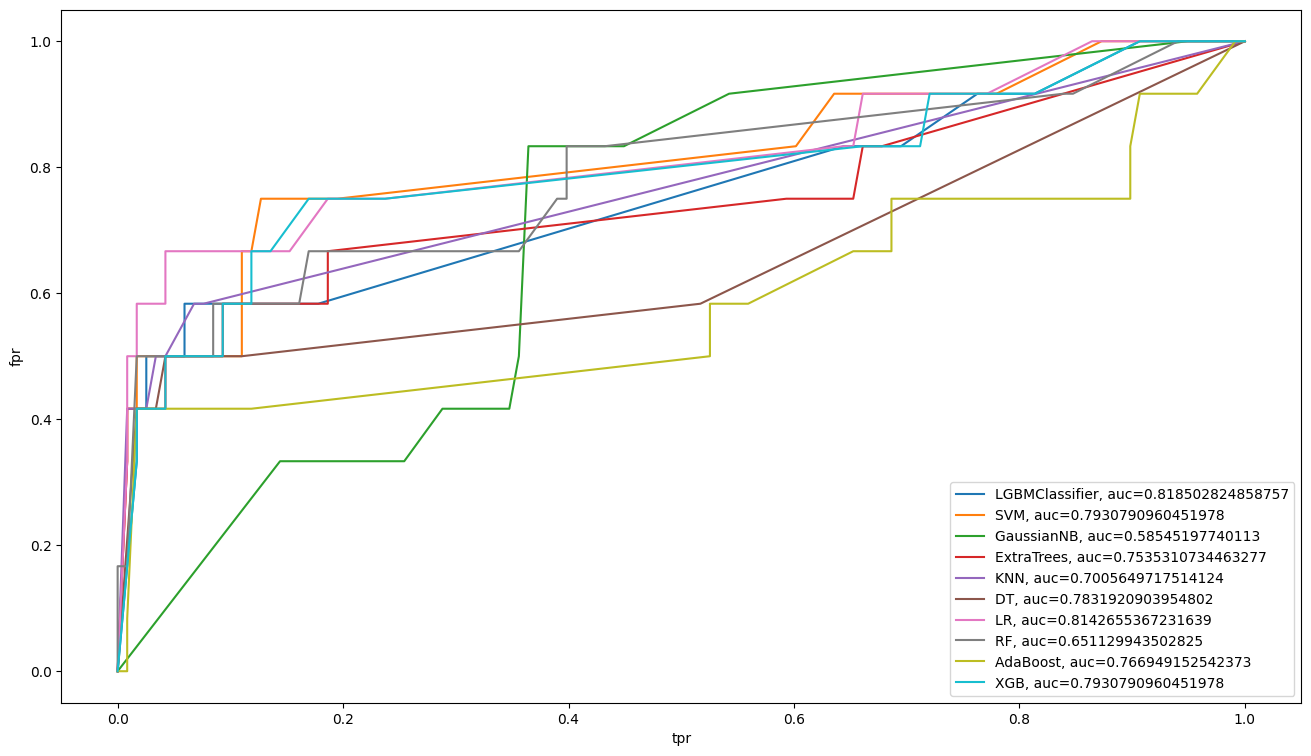

In [127]:
plt.rcParams["figure.figsize"] = [16, 9]
plt.plot(clf6["fpr"], clf6["tpr"], label="LGBMClassifier, auc="+str(clf10["auc"]))
plt.plot(clf9["fpr"], clf9["tpr"], label="SVM, auc="+str(clf2["auc"]))
plt.plot(clf5["fpr"], clf5["tpr"], label="GaussianNB, auc="+str(clf3["auc"]))
plt.plot(clf1["fpr"], clf1["tpr"], label="ExtraTrees, auc="+str(clf6["auc"]))
plt.plot(clf7["fpr"], clf7["tpr"], label="KNN, auc="+str(clf5["auc"]))
plt.plot(clf4["fpr"], clf4["tpr"], label="DT, auc="+str(clf8["auc"]))
plt.plot(clf10["fpr"], clf10["tpr"], label="LR, auc="+str(clf9["auc"]))
plt.plot(clf8["fpr"], clf8["tpr"], label="RF, auc="+str(clf4["auc"]))
plt.plot(clf3["fpr"], clf3["tpr"], label="AdaBoost, auc="+str(clf7["auc"]))
plt.plot(clf2["fpr"], clf2["tpr"], label="XGB, auc="+str(clf2["auc"]))

plt.xlabel("tpr")
plt.ylabel("fpr")
plt.legend(loc=4)
plt.show()

# **RandomOverSampling**

In [128]:
X_train = X_train_ros.reset_index(drop=True)
y_train = y_train_ros.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [129]:
n_samples, n_classes = X_train.shape[0], 2
class_weights = dict(zip(np.unique(y_train), n_samples / (n_classes * np.bincount(y_train))))

In [130]:
best_params_ros = []

## **ExtraTreesClassifier**

In [131]:
clf1 = ExtraTreesClassifier(random_state=seed, class_weight='balanced')
param_grid = {'n_estimators': [100, 500, 1000],
              'max_depth': [10, 25, 50, 100],
              'max_features': [int(sqrt(X.shape[1])), int(log2(X.shape[1]))],
              'min_samples_split' : [2, 5, 10], 
              'min_samples_leaf' : [1, 5, 10],
              'class_weight' : ['balanced', None]}

# Define the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(clf1, param_grid=param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the training data
grid_search.fit(X_train, y_train)
best_params_ros.append(grid_search.best_params_)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best hyperparameters to fit the model to the training data
clf_best = ExtraTreesClassifier(**grid_search.best_params_, random_state=seed)
model1 = clf_best.fit(X_train, y_train)

clf1 = print_auc(model1, X_train, y_train, X_test, y_test, 'ExtraTreesClassifier')
df1 = pd.DataFrame(data=[['ExtraTreesClassifier', clf1['f1'], clf1['auc'], clf1['auc_pr'], clf1['recall_sc'][0], clf1['recall_sc'][1], clf1['precision_sc'][0], clf1['precision_sc'][1]]], 
                          columns=['model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
df1.style.hide_index()

## **XGBClassifier**

In [ ]:
clf2 = xgb.XGBClassifier(objective='binary:logistic')
param_grid = {'learning_rate' : [0.01, 0.1, 0.2],
              'max_depth' : [3, 10, 25],
              'gamma' : [0.1, 0.5, 1.0],
              'subsample': [0.5, 0.8, 1.0],
              'colsample_bytree': [0.5, 0.8, 1.0],
              'scale_pos_weight': [1, imbalance_ratio]}

# Define the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(clf2, param_grid=param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the training data
grid_search.fit(X_train, y_train)
best_params_ros.append(grid_search.best_params_)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best hyperparameters to fit the model to the training data
clf_best = xgb.XGBClassifier(**grid_search.best_params_, objective='binary:logistic')
model2 = clf_best.fit(X_train, y_train)

clf2 = print_auc(model2, X_train, y_train, X_test, y_test, 'XGBClassifier')
df2 = pd.DataFrame(data=[['XGBClassifier', clf2['f1'], clf2['auc'], clf2['auc_pr'], clf2['recall_sc'][0], clf2['recall_sc'][1], clf2['precision_sc'][0], clf2['precision_sc'][1]]], 
                          columns=['model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
df2.style.hide_index()

Best hyperparameters:  {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.2, 'max_depth': 10, 'scale_pos_weight': 10.571428571428571, 'subsample': 0.5}
Best mean cross-validation score: 0.85
Train Result:
Accuracy Score: 91.31%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.990847   0.493827  0.913127    0.742337      0.948629
recall       0.913502   0.909091  0.913127    0.911297      0.913127
f1-score     0.950604   0.640000  0.913127    0.795302      0.924220
support    474.000000  44.000000  0.913127  518.000000    518.000000
_______________________________________________
Confusion Matrix: 
 [[433  41]
 [  4  40]]

Test Result:
Accuracy Score: 85.38%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.954128   0.333333  0.853846    0.643731      0.896824
recall     

model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
XGBClassifier,0.424242,0.793079,0.498210,0.881356,0.583333,0.954128,0.333333


## **AdaBoostClassifier**

In [ ]:
clf3 = AdaBoostClassifier(random_state=seed)
param_grid = {'n_estimators': [50, 100, 200],
              'learning_rate': [0.01, 0.1, 0.2],
              'base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=3)]}

# Define the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(clf3, param_grid=param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the training data
grid_search.fit(X_train, y_train)
best_params_ros.append(grid_search.best_params_)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best hyperparameters to fit the model to the training data
clf_best = AdaBoostClassifier(**grid_search.best_params_, random_state=seed)
model3 = clf_best.fit(X_train, y_train)

clf3 = print_auc(model3, X_train, y_train, X_test, y_test, 'AdaBoostClassifier')
df3 = pd.DataFrame(data=[['AdaBoostClassifier', clf3['f1'], clf3['auc'], clf3['auc_pr'], clf3['recall_sc'][0], clf3['recall_sc'][1], clf3['precision_sc'][0], clf3['precision_sc'][1]]], 
                          columns=['model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
df3.style.hide_index()

Best hyperparameters:  {'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.2, 'n_estimators': 200}
Best mean cross-validation score: 0.74
Train Result:
Accuracy Score: 96.72%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.971134   0.909091  0.967181    0.940112      0.965864
recall       0.993671   0.681818  0.967181    0.837745      0.967181
f1-score     0.982273   0.779221  0.967181    0.880747      0.965026
support    474.000000  44.000000  0.967181  518.000000    518.000000
_______________________________________________
Confusion Matrix: 
 [[471   3]
 [ 14  30]]

Test Result:
Accuracy Score: 91.54%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.942149   0.555556  0.915385    0.748852      0.906463
recall       0.966102   0.416667  0.915385    0.6

model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
AdaBoostClassifier,0.476190,0.585452,0.283489,0.966102,0.416667,0.942149,0.555556


## **DecisionTreeClassifier**

In [ ]:
clf4 = DecisionTreeClassifier(random_state=seed)
param_grid = {'min_samples_split': [2, 5, 10, 20],
              'max_depth': [2, 3, 4, 5, None],
              'min_samples_leaf': [1, 2, 4, 8],
              'criterion' : ['gini', 'entropy', 'log_loss'],
              'max_features': ['auto', int(sqrt(X.shape[1])), int(log2(X.shape[1]))]}

# Define the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(clf4, param_grid=param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the training data
grid_search.fit(X_train, y_train)
best_params_ros.append(grid_search.best_params_)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best hyperparameters to fit the model to the training data
clf_best = DecisionTreeClassifier(**grid_search.best_params_, random_state=seed)
model4 = clf_best.fit(X_train, y_train)

clf4 = print_auc(model4, X_train, y_train, X_test, y_test, 'DecisionTreeClassifier')
df4 = pd.DataFrame(data=[['DecisionTreeClassifier', clf4['f1'], clf4['auc'], clf4['auc_pr'], clf4['recall_sc'][0], clf4['recall_sc'][1], clf4['precision_sc'][0], clf4['precision_sc'][1]]], 
                          columns=['model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
df4.style.hide_index()

Best hyperparameters:  {'criterion': 'gini', 'max_depth': None, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best mean cross-validation score: 0.68
Train Result:
Accuracy Score: 96.72%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.969199   0.935484  0.967181    0.952342      0.966335
recall       0.995781   0.659091  0.967181    0.827436      0.967181
f1-score     0.982310   0.773333  0.967181    0.877822      0.964559
support    474.000000  44.000000  0.967181  518.000000    518.000000
_______________________________________________
Confusion Matrix: 
 [[472   2]
 [ 15  29]]

Test Result:
Accuracy Score: 92.31%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.942623   0.625000  0.923077    0.783811      0.913304
recall       0.974576   0.416667  0.92307

model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
DecisionTreeClassifier,0.500000,0.651130,0.461142,0.974576,0.416667,0.942623,0.625000


## **GaussianNB**

In [ ]:
clf5 = GaussianNB()
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

# Define the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(clf5, param_grid=param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the training data
grid_search.fit(X_train, y_train)
best_params_ros.append(grid_search.best_params_)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best hyperparameters to fit the model to the training data
clf_best = GaussianNB(**grid_search.best_params_)
model5 = clf_best.fit(X_train, y_train)

clf5 = print_auc(model5, X_train, y_train, X_test, y_test, 'GaussianNB')
df5 = pd.DataFrame(data=[['GaussianNB', clf5['f1'], clf5['auc'], clf5['auc_pr'], clf5['recall_sc'][0], clf5['recall_sc'][1], clf5['precision_sc'][0], clf5['precision_sc'][1]]], 
                          columns=['model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
df5.style.hide_index()

Best hyperparameters:  {'var_smoothing': 1e-05}
Best mean cross-validation score: 0.68
Train Result:
Accuracy Score: 82.43%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.957041   0.262626  0.824324    0.609833      0.898056
recall       0.845992   0.590909  0.824324    0.718450      0.824324
f1-score     0.898096   0.363636  0.824324    0.630866      0.852698
support    474.000000  44.000000  0.824324  518.000000    518.000000
_______________________________________________
Confusion Matrix: 
 [[401  73]
 [ 18  26]]

Test Result:
Accuracy Score: 67.69%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.922222   0.125000  0.676923    0.523611      0.848632
recall       0.703390   0.416667  0.676923    0.560028      0.676923
f1-score     0.798077   0.192308  0.676923    0.495192

model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
GaussianNB,0.192308,0.700565,0.293542,0.703390,0.416667,0.922222,0.125000


## **LGBMClassifier**

In [ ]:
clf6 = lgb.LGBMClassifier()
param_grid = {'num_leaves': [10, 20, 30],
              'max_depth': [3, 5, 7],
              'learning_rate': [0.01, 0.1],
              'n_estimators': [50, 100, 200],
              'min_child_samples': [10, 20, 30],
              'subsample': [0.8, 0.9, 1.0],
              'colsample_bytree': [0.8, 0.9, 1.0],
              'class_weight' : ['balanced', None, class_weights]}
         
# Define the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(clf6, param_grid=param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the training data
grid_search.fit(X_train, y_train)
best_params_ros.append(grid_search.best_params_)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best hyperparameters to fit the model to the training data
clf_best = lgb.LGBMClassifier(**grid_search.best_params_)
model6 = clf_best.fit(X_train, y_train)

clf6 = print_auc(model6, X_train, y_train, X_test, y_test, 'LGBMClassifier')
df6 = pd.DataFrame(data=[['LGBMClassifier', clf6['f1'], clf6['auc'], clf6['auc_pr'], clf6['recall_sc'][0], clf6['recall_sc'][1], clf6['precision_sc'][0], clf6['precision_sc'][1]]], 
                          columns=['model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
df6.style.hide_index()

Best hyperparameters:  {'class_weight': 'balanced', 'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_samples': 10, 'n_estimators': 50, 'num_leaves': 10, 'subsample': 0.8}
Best mean cross-validation score: 0.86
Train Result:
Accuracy Score: 90.54%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.990762   0.470588  0.905405    0.730675      0.946577
recall       0.905063   0.909091  0.905405    0.907077      0.905405
f1-score     0.945976   0.620155  0.905405    0.783065      0.918300
support    474.000000  44.000000  0.905405  518.000000    518.000000
_______________________________________________
Confusion Matrix: 
 [[429  45]
 [  4  40]]

Test Result:
Accuracy Score: 82.31%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.952381   0.280000  0.823077  

model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
LGBMClassifier,0.378378,0.753531,0.492538,0.847458,0.583333,0.952381,0.280000


## **KNeighborsClassifier**

In [ ]:
clf7 = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7],
              'weights': ['uniform', 'distance'],
              'p': [1, 2],
              'algorithm': ['brute'],
              'leaf_size': [10, 30, 50]}

# Define the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(clf7, param_grid=param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the training data
grid_search.fit(X_train, y_train)
best_params_ros.append(grid_search.best_params_)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best hyperparameters to fit the model to the training data
clf_best = KNeighborsClassifier(**grid_search.best_params_)
model7 = clf_best.fit(X_train, y_train)

clf7 = print_auc(model7, X_train, y_train, X_test, y_test, 'KNeiborsClassifier')
df7 = pd.DataFrame(data=[['KNeiborsClassifier', clf7['f1'], clf7['auc'], clf7['auc_pr'], clf7['recall_sc'][0], clf7['recall_sc'][1], clf7['precision_sc'][0], clf7['precision_sc'][1]]], 
                          columns=['model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
df7.style.hide_index()

Best hyperparameters:  {'algorithm': 'brute', 'leaf_size': 10, 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Best mean cross-validation score: 0.66
Train Result:
Accuracy Score: 96.72%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.969199   0.935484  0.967181    0.952342      0.966335
recall       0.995781   0.659091  0.967181    0.827436      0.967181
f1-score     0.982310   0.773333  0.967181    0.877822      0.964559
support    474.000000  44.000000  0.967181  518.000000    518.000000
_______________________________________________
Confusion Matrix: 
 [[472   2]
 [ 15  29]]

Test Result:
Accuracy Score: 93.08%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.943089   0.714286  0.930769    0.828688      0.921969
recall       0.983051   0.416667  0.930769    0.699859     

model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
KNeiborsClassifier,0.526316,0.766949,0.585534,0.983051,0.416667,0.943089,0.714286


## **RandomForestClassifier**

In [ ]:
clf8 = RandomForestClassifier(random_state=seed)
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [3, 5, 7],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['sqrt', 'log2'],
              'criterion': ['gini', 'entropy']}

# Define the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(clf8, param_grid=param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the training data
grid_search.fit(X_train, y_train)
best_params_ros.append(grid_search.best_params_)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best hyperparameters to fit the model to the training data
clf_best = RandomForestClassifier(**grid_search.best_params_, random_state=seed)
model8 = clf_best.fit(X_train, y_train)

clf8 = print_auc(model8, X_train, y_train, X_test, y_test, 'RandomForestClassifier')
df8 = pd.DataFrame(data=[['RandomForestClassifier', clf8['f1'], clf8['auc'], clf8['auc_pr'], clf8['recall_sc'][0], clf8['recall_sc'][1], clf8['precision_sc'][0], clf8['precision_sc'][1]]], 
                          columns=['model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
df8.style.hide_index()

Best hyperparameters:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best mean cross-validation score: 0.65
Train Result:
Accuracy Score: 93.82%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.942000   0.833333  0.938224    0.887667      0.932770
recall       0.993671   0.340909  0.938224    0.667290      0.938224
f1-score     0.967146   0.483871  0.938224    0.725508      0.926095
support    474.000000  44.000000  0.938224  518.000000    518.000000
_______________________________________________
Confusion Matrix: 
 [[471   3]
 [ 29  15]]

Test Result:
Accuracy Score: 93.08%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.950413   0.666667  0.930769    0.808540      0.924221
recall       0.

model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
RandomForestClassifier,0.571429,0.783192,0.505365,0.974576,0.500000,0.950413,0.666667


## **SVC**

In [ ]:
clf9 = SVC(probability=True)
param_grid = {'C': [0.1, 1, 10],
              'kernel': ['linear', 'poly', 'rbf'],
              'degree': [2, 3, 4],
              'gamma': ['scale', 'auto'],
              'class_weight': [None, 'balanced']}

# Define the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(clf9, param_grid=param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the training data
grid_search.fit(X_train, y_train)
best_params_ros.append(grid_search.best_params_)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best hyperparameters to fit the model to the training data
clf_best = SVC(**grid_search.best_params_, probability=True)
model9 = clf_best.fit(X_train, y_train)

clf9 = print_auc(model9, X_train, y_train, X_test, y_test, 'SVM')
df9 = pd.DataFrame(data=[['SVM', clf9['f1'], clf9['auc'], clf9['auc_pr'], clf9['recall_sc'][0], clf9['recall_sc'][1], clf9['precision_sc'][0], clf9['precision_sc'][1]]], 
                          columns=['model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
df9.style.hide_index()

Best hyperparameters:  {'C': 10, 'class_weight': 'balanced', 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Best mean cross-validation score: 0.84
Train Result:
Accuracy Score: 91.70%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.990888   0.506329  0.916988    0.748609      0.949729
recall       0.917722   0.909091  0.916988    0.913406      0.916988
f1-score     0.952903   0.650407  0.916988    0.801655      0.927208
support    474.000000  44.000000  0.916988  518.000000    518.000000
_______________________________________________
Confusion Matrix: 
 [[435  39]
 [  4  40]]

Test Result:
Accuracy Score: 86.92%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.963303   0.380952  0.869231    0.672128      0.909547
recall       0.889831   0.666667  0.869231    0.778249     

model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
SVM,0.484848,0.814266,0.554175,0.889831,0.666667,0.963303,0.380952


## **LogisticRegression**

In [ ]:
clf10 = LogisticRegression()
param_grid = {'penalty': ['l1', 'l2'],
              'C': [0.1, 1, 10],
              'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag'],
              'max_iter': [100, 200, 500],
              'class_weight': [None, 'balanced']}

grid_search = GridSearchCV(clf10, param_grid=param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the training data
grid_search.fit(X_train, y_train)
best_params_ros.append(grid_search.best_params_)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best hyperparameters to fit the model to the training data
clf_best = LogisticRegression(**grid_search.best_params_, random_state=seed)
model10 = clf_best.fit(X_train, y_train)

clf10 = print_auc(model10, X_train, y_train, X_test, y_test, 'LogisticRegression')
df10 = pd.DataFrame(data=[['LogisticRegression', clf10['f1'], clf10['auc'], clf10['auc_pr'], clf10['recall_sc'][0], clf10['recall_sc'][1], clf10['precision_sc'][0], clf10['precision_sc'][1]]], 
                          columns=['model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
df10.style.hide_index()

Best hyperparameters:  {'C': 10, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best mean cross-validation score: 0.83
Train Result:
Accuracy Score: 91.51%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.990868   0.500000  0.915058    0.745434      0.949172
recall       0.915612   0.909091  0.915058    0.912351      0.915058
f1-score     0.951754   0.645161  0.915058    0.798458      0.925712
support    474.000000  44.000000  0.915058  518.000000    518.000000
_______________________________________________
Confusion Matrix: 
 [[434  40]
 [  4  40]]

Test Result:
Accuracy Score: 86.15%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.962963   0.363636  0.861538    0.663300      0.907641
recall       0.881356   0.666667  0.861538    0.77401

model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
LogisticRegression,0.470588,0.818503,0.610812,0.881356,0.666667,0.962963,0.363636


In [ ]:
df_ros = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10]
df_finale_ros = pd.concat(df)
df_finale_ros

,model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
0,ExtraTreesClassifier,0.350000,0.743997,0.505599,0.822034,0.583333,0.950980,0.250000
0,XGBClassifier,0.424242,0.793079,0.498210,0.881356,0.583333,0.954128,0.333333
0,AdaBoostClassifier,0.476190,0.585452,0.283489,0.966102,0.416667,0.942149,0.555556
0,DecisionTreeClassifier,0.500000,0.651130,0.461142,0.974576,0.416667,0.942623,0.625000
0,GaussianNB,0.192308,0.700565,0.293542,0.703390,0.416667,0.922222,0.125000
0,LGBMClassifier,0.378378,0.753531,0.492538,0.847458,0.583333,0.952381,0.280000
0,KNeiborsClassifier,0.526316,0.766949,0.585534,0.983051,0.416667,0.943089,0.714286
0,RandomForestClassifier,0.571429,0.783192,0.505365,0.974576,0.500000,0.950413,0.666667
0,SVM,0.484848,0.814266,0.554175,0.889831,0.666667,0.963303,0.380952
0,LogisticRegression,0.470588,0.818503,0.610812,0.881356,0.666667,0.962963,0.363636


In [ ]:
df_finale_ros.to_csv('df_finale_ros.csv', index=False)

# **SMOTE**

In [ ]:
X_train = X_train_sm.reset_index(drop=True)
y_train = y_train_sm.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
n_samples, n_classes = X_train.shape[0], 2
class_weights = dict(zip(np.unique(y_train), n_samples / (n_classes * np.bincount(y_train))))

In [ ]:
best_para_sm = []

## **ExtraTreesClassifier**

In [ ]:
clf1 = ExtraTreesClassifier(random_state=seed, class_weight='balanced')
param_grid = {'n_estimators': [100, 500, 1000],
              'max_depth': [10, 25, 50, 100],
              'max_features': [int(sqrt(X.shape[1])), int(log2(X.shape[1]))],
              'min_samples_split' : [2, 5, 10], 
              'min_samples_leaf' : [1, 5, 10],
              'class_weight' : ['balanced', None]}

# Define the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(clf1, param_grid=param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the training data
grid_search.fit(X_train, y_train)
best_params_sm.append(grid_search.best_params_)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best hyperparameters to fit the model to the training data
clf_best = ExtraTreesClassifier(**grid_search.best_params_, random_state=seed)
model1 = clf_best.fit(X_train, y_train)

clf1 = print_auc(model1, X_train, y_train, X_test, y_test, 'ExtraTreesClassifier')
df1 = pd.DataFrame(data=[['ExtraTreesClassifier', clf1['f1'], clf1['auc'], clf1['auc_pr'], clf1['recall_sc'][0], clf1['recall_sc'][1], clf1['precision_sc'][0], clf1['precision_sc'][1]]], 
                          columns=['model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
df1.style.hide_index()

## **XGBClassifier**

In [ ]:
clf2 = xgb.XGBClassifier(objective='binary:logistic')
param_grid = {'learning_rate' : [0.01, 0.1, 0.2],
              'max_depth' : [3, 10, 25],
              'gamma' : [0.1, 0.5, 1.0],
              'subsample': [0.5, 0.8, 1.0],
              'colsample_bytree': [0.5, 0.8, 1.0],
              'scale_pos_weight': [1, imbalance_ratio]}

# Define the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(clf2, param_grid=param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the training data
grid_search.fit(X_train, y_train)
best_params_sm.append(grid_search.best_params_)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best hyperparameters to fit the model to the training data
clf_best = xgb.XGBClassifier(**grid_search.best_params_, objective='binary:logistic')
model2 = clf_best.fit(X_train, y_train)

clf2 = print_auc(model2, X_train, y_train, X_test, y_test, 'XGBClassifier')
df2 = pd.DataFrame(data=[['XGBClassifier', clf2['f1'], clf2['auc'], clf2['auc_pr'], clf2['recall_sc'][0], clf2['recall_sc'][1], clf2['precision_sc'][0], clf2['precision_sc'][1]]], 
                          columns=['model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
df2.style.hide_index()

Best hyperparameters:  {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.2, 'max_depth': 10, 'scale_pos_weight': 10.571428571428571, 'subsample': 0.5}
Best mean cross-validation score: 0.85
Train Result:
Accuracy Score: 91.31%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.990847   0.493827  0.913127    0.742337      0.948629
recall       0.913502   0.909091  0.913127    0.911297      0.913127
f1-score     0.950604   0.640000  0.913127    0.795302      0.924220
support    474.000000  44.000000  0.913127  518.000000    518.000000
_______________________________________________
Confusion Matrix: 
 [[433  41]
 [  4  40]]

Test Result:
Accuracy Score: 85.38%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.954128   0.333333  0.853846    0.643731      0.896824
recall     

model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
XGBClassifier,0.424242,0.793079,0.498210,0.881356,0.583333,0.954128,0.333333


## **AdaBoostClassifier**

In [ ]:
clf3 = AdaBoostClassifier(random_state=seed)
param_grid = {'n_estimators': [50, 100, 200],
              'learning_rate': [0.01, 0.1, 0.2],
              'base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=3)]}

# Define the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(clf3, param_grid=param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the training data
grid_search.fit(X_train, y_train)
best_params_sm.append(grid_search.best_params_)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best hyperparameters to fit the model to the training data
clf_best = AdaBoostClassifier(**grid_search.best_params_, random_state=seed)
model3 = clf_best.fit(X_train, y_train)

clf3 = print_auc(model3, X_train, y_train, X_test, y_test, 'AdaBoostClassifier')
df3 = pd.DataFrame(data=[['AdaBoostClassifier', clf3['f1'], clf3['auc'], clf3['auc_pr'], clf3['recall_sc'][0], clf3['recall_sc'][1], clf3['precision_sc'][0], clf3['precision_sc'][1]]], 
                          columns=['model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
df3.style.hide_index()

Best hyperparameters:  {'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.2, 'n_estimators': 200}
Best mean cross-validation score: 0.74
Train Result:
Accuracy Score: 96.72%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.971134   0.909091  0.967181    0.940112      0.965864
recall       0.993671   0.681818  0.967181    0.837745      0.967181
f1-score     0.982273   0.779221  0.967181    0.880747      0.965026
support    474.000000  44.000000  0.967181  518.000000    518.000000
_______________________________________________
Confusion Matrix: 
 [[471   3]
 [ 14  30]]

Test Result:
Accuracy Score: 91.54%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.942149   0.555556  0.915385    0.748852      0.906463
recall       0.966102   0.416667  0.915385    0.6

model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
AdaBoostClassifier,0.476190,0.585452,0.283489,0.966102,0.416667,0.942149,0.555556


## **DecisionTreeClassifier**

In [ ]:
clf4 = DecisionTreeClassifier(random_state=seed)
param_grid = {'min_samples_split': [2, 5, 10, 20],
              'max_depth': [2, 3, 4, 5, None],
              'min_samples_leaf': [1, 2, 4, 8],
              'criterion' : ['gini', 'entropy', 'log_loss'],
              'max_features': ['auto', int(sqrt(X.shape[1])), int(log2(X.shape[1]))]}

# Define the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(clf4, param_grid=param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the training data
grid_search.fit(X_train, y_train)
best_params_sm.append(grid_search.best_params_)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best hyperparameters to fit the model to the training data
clf_best = DecisionTreeClassifier(**grid_search.best_params_, random_state=seed)
model4 = clf_best.fit(X_train, y_train)

clf4 = print_auc(model4, X_train, y_train, X_test, y_test, 'DecisionTreeClassifier')
df4 = pd.DataFrame(data=[['DecisionTreeClassifier', clf4['f1'], clf4['auc'], clf4['auc_pr'], clf4['recall_sc'][0], clf4['recall_sc'][1], clf4['precision_sc'][0], clf4['precision_sc'][1]]], 
                          columns=['model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
df4.style.hide_index()

Best hyperparameters:  {'criterion': 'gini', 'max_depth': None, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best mean cross-validation score: 0.68
Train Result:
Accuracy Score: 96.72%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.969199   0.935484  0.967181    0.952342      0.966335
recall       0.995781   0.659091  0.967181    0.827436      0.967181
f1-score     0.982310   0.773333  0.967181    0.877822      0.964559
support    474.000000  44.000000  0.967181  518.000000    518.000000
_______________________________________________
Confusion Matrix: 
 [[472   2]
 [ 15  29]]

Test Result:
Accuracy Score: 92.31%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.942623   0.625000  0.923077    0.783811      0.913304
recall       0.974576   0.416667  0.92307

model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
DecisionTreeClassifier,0.500000,0.651130,0.461142,0.974576,0.416667,0.942623,0.625000


## **GaussianNB**

In [ ]:
clf5 = GaussianNB()
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

# Define the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(clf5, param_grid=param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the training data
grid_search.fit(X_train, y_train)
best_params_sm.append(grid_search.best_params_)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best hyperparameters to fit the model to the training data
clf_best = GaussianNB(**grid_search.best_params_)
model5 = clf_best.fit(X_train, y_train)

clf5 = print_auc(model5, X_train, y_train, X_test, y_test, 'GaussianNB')
df5 = pd.DataFrame(data=[['GaussianNB', clf5['f1'], clf5['auc'], clf5['auc_pr'], clf5['recall_sc'][0], clf5['recall_sc'][1], clf5['precision_sc'][0], clf5['precision_sc'][1]]], 
                          columns=['model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
df5.style.hide_index()

Best hyperparameters:  {'var_smoothing': 1e-05}
Best mean cross-validation score: 0.68
Train Result:
Accuracy Score: 82.43%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.957041   0.262626  0.824324    0.609833      0.898056
recall       0.845992   0.590909  0.824324    0.718450      0.824324
f1-score     0.898096   0.363636  0.824324    0.630866      0.852698
support    474.000000  44.000000  0.824324  518.000000    518.000000
_______________________________________________
Confusion Matrix: 
 [[401  73]
 [ 18  26]]

Test Result:
Accuracy Score: 67.69%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.922222   0.125000  0.676923    0.523611      0.848632
recall       0.703390   0.416667  0.676923    0.560028      0.676923
f1-score     0.798077   0.192308  0.676923    0.495192

model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
GaussianNB,0.192308,0.700565,0.293542,0.703390,0.416667,0.922222,0.125000


## **LGBMClassifier**

In [ ]:
clf6 = lgb.LGBMClassifier()
param_grid = {'num_leaves': [10, 20, 30],
              'max_depth': [3, 5, 7],
              'learning_rate': [0.01, 0.1],
              'n_estimators': [50, 100, 200],
              'min_child_samples': [10, 20, 30],
              'subsample': [0.8, 0.9, 1.0],
              'colsample_bytree': [0.8, 0.9, 1.0],
              'class_weight' : ['balanced', None, class_weights]}
         
# Define the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(clf6, param_grid=param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the training data
grid_search.fit(X_train, y_train)
best_params_sm.append(grid_search.best_params_)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best hyperparameters to fit the model to the training data
clf_best = lgb.LGBMClassifier(**grid_search.best_params_)
model6 = clf_best.fit(X_train, y_train)

clf6 = print_auc(model6, X_train, y_train, X_test, y_test, 'LGBMClassifier')
df6 = pd.DataFrame(data=[['LGBMClassifier', clf6['f1'], clf6['auc'], clf6['auc_pr'], clf6['recall_sc'][0], clf6['recall_sc'][1], clf6['precision_sc'][0], clf6['precision_sc'][1]]], 
                          columns=['model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
df6.style.hide_index()

Best hyperparameters:  {'class_weight': 'balanced', 'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_samples': 10, 'n_estimators': 50, 'num_leaves': 10, 'subsample': 0.8}
Best mean cross-validation score: 0.86
Train Result:
Accuracy Score: 90.54%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.990762   0.470588  0.905405    0.730675      0.946577
recall       0.905063   0.909091  0.905405    0.907077      0.905405
f1-score     0.945976   0.620155  0.905405    0.783065      0.918300
support    474.000000  44.000000  0.905405  518.000000    518.000000
_______________________________________________
Confusion Matrix: 
 [[429  45]
 [  4  40]]

Test Result:
Accuracy Score: 82.31%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.952381   0.280000  0.823077  

model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
LGBMClassifier,0.378378,0.753531,0.492538,0.847458,0.583333,0.952381,0.280000


## **KNeighborsClassifier**

In [ ]:
clf7 = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7],
              'weights': ['uniform', 'distance'],
              'p': [1, 2],
              'algorithm': ['brute'],
              'leaf_size': [10, 30, 50]}

# Define the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(clf7, param_grid=param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the training data
grid_search.fit(X_train, y_train)
best_params_sm.append(grid_search.best_params_)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best hyperparameters to fit the model to the training data
clf_best = KNeighborsClassifier(**grid_search.best_params_)
model7 = clf_best.fit(X_train, y_train)

clf7 = print_auc(model7, X_train, y_train, X_test, y_test, 'KNeiborsClassifier')
df7 = pd.DataFrame(data=[['KNeiborsClassifier', clf7['f1'], clf7['auc'], clf7['auc_pr'], clf7['recall_sc'][0], clf7['recall_sc'][1], clf7['precision_sc'][0], clf7['precision_sc'][1]]], 
                          columns=['model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
df7.style.hide_index()

Best hyperparameters:  {'algorithm': 'brute', 'leaf_size': 10, 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Best mean cross-validation score: 0.66
Train Result:
Accuracy Score: 96.72%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.969199   0.935484  0.967181    0.952342      0.966335
recall       0.995781   0.659091  0.967181    0.827436      0.967181
f1-score     0.982310   0.773333  0.967181    0.877822      0.964559
support    474.000000  44.000000  0.967181  518.000000    518.000000
_______________________________________________
Confusion Matrix: 
 [[472   2]
 [ 15  29]]

Test Result:
Accuracy Score: 93.08%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.943089   0.714286  0.930769    0.828688      0.921969
recall       0.983051   0.416667  0.930769    0.699859     

model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
KNeiborsClassifier,0.526316,0.766949,0.585534,0.983051,0.416667,0.943089,0.714286


## **RandomForestClassifier**

In [ ]:
clf8 = RandomForestClassifier(random_state=seed)
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [3, 5, 7],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['sqrt', 'log2'],
              'criterion': ['gini', 'entropy']}

# Define the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(clf8, param_grid=param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the training data
grid_search.fit(X_train, y_train)
best_params_sm.append(grid_search.best_params_)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best hyperparameters to fit the model to the training data
clf_best = RandomForestClassifier(**grid_search.best_params_, random_state=seed)
model8 = clf_best.fit(X_train, y_train)

clf8 = print_auc(model8, X_train, y_train, X_test, y_test, 'RandomForestClassifier')
df8 = pd.DataFrame(data=[['RandomForestClassifier', clf8['f1'], clf8['auc'], clf8['auc_pr'], clf8['recall_sc'][0], clf8['recall_sc'][1], clf8['precision_sc'][0], clf8['precision_sc'][1]]], 
                          columns=['model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
df8.style.hide_index()

Best hyperparameters:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best mean cross-validation score: 0.65
Train Result:
Accuracy Score: 93.82%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.942000   0.833333  0.938224    0.887667      0.932770
recall       0.993671   0.340909  0.938224    0.667290      0.938224
f1-score     0.967146   0.483871  0.938224    0.725508      0.926095
support    474.000000  44.000000  0.938224  518.000000    518.000000
_______________________________________________
Confusion Matrix: 
 [[471   3]
 [ 29  15]]

Test Result:
Accuracy Score: 93.08%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.950413   0.666667  0.930769    0.808540      0.924221
recall       0.

model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
RandomForestClassifier,0.571429,0.783192,0.505365,0.974576,0.500000,0.950413,0.666667


## **SVC**

In [ ]:
clf9 = SVC(probability=True)
param_grid = {'C': [0.1, 1, 10],
              'kernel': ['linear', 'poly', 'rbf'],
              'degree': [2, 3, 4],
              'gamma': ['scale', 'auto'],
              'class_weight': [None, 'balanced']}

# Define the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(clf9, param_grid=param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the training data
grid_search.fit(X_train, y_train)
best_params_sm.append(grid_search.best_params_)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best hyperparameters to fit the model to the training data
clf_best = SVC(**grid_search.best_params_, probability=True)
model9 = clf_best.fit(X_train, y_train)

clf9 = print_auc(model9, X_train, y_train, X_test, y_test, 'SVM')
df9 = pd.DataFrame(data=[['SVM', clf9['f1'], clf9['auc'], clf9['auc_pr'], clf9['recall_sc'][0], clf9['recall_sc'][1], clf9['precision_sc'][0], clf9['precision_sc'][1]]], 
                          columns=['model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
df9.style.hide_index()

Best hyperparameters:  {'C': 10, 'class_weight': 'balanced', 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Best mean cross-validation score: 0.84
Train Result:
Accuracy Score: 91.70%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.990888   0.506329  0.916988    0.748609      0.949729
recall       0.917722   0.909091  0.916988    0.913406      0.916988
f1-score     0.952903   0.650407  0.916988    0.801655      0.927208
support    474.000000  44.000000  0.916988  518.000000    518.000000
_______________________________________________
Confusion Matrix: 
 [[435  39]
 [  4  40]]

Test Result:
Accuracy Score: 86.92%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.963303   0.380952  0.869231    0.672128      0.909547
recall       0.889831   0.666667  0.869231    0.778249     

model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
SVM,0.484848,0.814266,0.554175,0.889831,0.666667,0.963303,0.380952


## **LogisticRegression**

In [ ]:
clf10 = LogisticRegression()
param_grid = {'penalty': ['l1', 'l2'],
              'C': [0.1, 1, 10],
              'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag'],
              'max_iter': [100, 200, 500],
              'class_weight': [None, 'balanced']}

grid_search = GridSearchCV(clf10, param_grid=param_grid, cv=10, scoring='balanced_accuracy', n_jobs=-1)

# Fit the GridSearchCV object with the training data
grid_search.fit(X_train, y_train)
best_params_sm.append(grid_search.best_params_)

# Print the best hyperparameters and the corresponding mean cross-validation score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean cross-validation score: {:.2f}".format(grid_search.best_score_))

# Use the best hyperparameters to fit the model to the training data
clf_best = LogisticRegression(**grid_search.best_params_, random_state=seed)
model10 = clf_best.fit(X_train, y_train)

clf10 = print_auc(model10, X_train, y_train, X_test, y_test, 'LogisticRegression')
df10 = pd.DataFrame(data=[['LogisticRegression', clf10['f1'], clf10['auc'], clf10['auc_pr'], clf10['recall_sc'][0], clf10['recall_sc'][1], clf10['precision_sc'][0], clf10['precision_sc'][1]]], 
                          columns=['model', 'f1_score', 'auc', 'auc_pr', 'recall_classe(0)', 'recall_classe(1)', 'precision_classe(0)', 'precision_classe(1)'])
df10.style.hide_index()

Best hyperparameters:  {'C': 10, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best mean cross-validation score: 0.83
Train Result:
Accuracy Score: 91.51%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.990868   0.500000  0.915058    0.745434      0.949172
recall       0.915612   0.909091  0.915058    0.912351      0.915058
f1-score     0.951754   0.645161  0.915058    0.798458      0.925712
support    474.000000  44.000000  0.915058  518.000000    518.000000
_______________________________________________
Confusion Matrix: 
 [[434  40]
 [  4  40]]

Test Result:
Accuracy Score: 86.15%
_______________________________________________
CLASSIFICATION REPORT:
                    0          1  accuracy   macro avg  weighted avg
precision    0.962963   0.363636  0.861538    0.663300      0.907641
recall       0.881356   0.666667  0.861538    0.77401

model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
LogisticRegression,0.470588,0.818503,0.610812,0.881356,0.666667,0.962963,0.363636


In [ ]:
df_sm = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10]
df_finale_sm = pd.concat(df)
df_finale_sm

,model,f1_score,auc,auc_pr,recall_classe(0),recall_classe(1),precision_classe(0),precision_classe(1)
0,ExtraTreesClassifier,0.350000,0.743997,0.505599,0.822034,0.583333,0.950980,0.250000
0,XGBClassifier,0.424242,0.793079,0.498210,0.881356,0.583333,0.954128,0.333333
0,AdaBoostClassifier,0.476190,0.585452,0.283489,0.966102,0.416667,0.942149,0.555556
0,DecisionTreeClassifier,0.500000,0.651130,0.461142,0.974576,0.416667,0.942623,0.625000
0,GaussianNB,0.192308,0.700565,0.293542,0.703390,0.416667,0.922222,0.125000
0,LGBMClassifier,0.378378,0.753531,0.492538,0.847458,0.583333,0.952381,0.280000
0,KNeiborsClassifier,0.526316,0.766949,0.585534,0.983051,0.416667,0.943089,0.714286
0,RandomForestClassifier,0.571429,0.783192,0.505365,0.974576,0.500000,0.950413,0.666667
0,SVM,0.484848,0.814266,0.554175,0.889831,0.666667,0.963303,0.380952
0,LogisticRegression,0.470588,0.818503,0.610812,0.881356,0.666667,0.962963,0.363636


In [ ]:
df_finale_sm.to_csv('df_finalef_sm.csv', index=False)